In [2]:
import pandas as pd
import numpy as np
import requests
import json
import os
from dotenv import load_dotenv
import folium
from datetime import datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from deap import base, creator, tools, algorithms
import random
from geopy.distance import geodesic
import warnings
import joblib
from folium.plugins import MarkerCluster
warnings.filterwarnings('ignore')

load_dotenv()

MAPMYINDIA_API_KEY = os.getenv('MAPMYINDIA_API_KEY')
WEATHER_API_KEY = os.getenv('WEATHER_API_KEY')
GOOGLE_MAPS_API_KEY = os.getenv('GOOGLE_MAPS_API_KEY')

print("Environment loaded successfully!")


Environment loaded successfully!


In [3]:
df = pd.read_excel('../data/Starbucks_Mumbai_Dataset.xlsx')

print(f"Dataset shape: {df.shape}")
print("\nDataset columns:")
print(df.columns.tolist())

df = df.dropna(subset=['Latitude', 'Longitude'])
df['store_id'] = df.index

df_clean = df[['store_id', 'Store Name', 'Latitude', 'Longitude', 
               'Street Address', 'City', 'State']].copy()

print(f"\nCleaned dataset shape: {df_clean.shape}")
print("\nSample locations:")
df_clean.head()



Dataset shape: (32, 13)

Dataset columns:
['Brand', 'Store Number', 'Store Name', 'Ownership Type', 'Street Address', 'City', 'State', 'Country', 'Pincode', 'Phone Number', 'Timezone', 'Longitude', 'Latitude']

Cleaned dataset shape: (32, 7)

Sample locations:


,store_id,Store Name,Latitude,Longitude,Street Address,City,State
0,0,Prabhadevi,19.01,72.82,"Upper Ground Floor, Century Bhavan, Century Ba...",Mumbai,MH
1,1,Malad West - Infiniti Mall,19.18,72.83,"Upper Ground Floor, Infiniti Mall, Link Road, ...",Mumbai,MH
2,2,Santacruz West,19.08,72.83,"Grd Flr Red Chillies Entertainment Bldg, Jct o...",Mumbai,MH
3,3,Nariman Point,18.93,72.82,"Ground Floor, Shree Nirmal Building, Behind Tr...",Mumbai,MH
4,4,Andheri West - Four Bunglows,19.13,72.82,"Kokilaben Dhirubhai Ambani Hospital, Four Bung...",Mumbai,MH


In [4]:
def get_weather_data(lat, lon):
    """Get current weather data from weatherapi.com"""
    base_url = "http://api.weatherapi.com/v1/current.json"
    
    params = {
        'key': WEATHER_API_KEY,
        'q': f"{lat},{lon}",
        'aqi': 'yes'
    }
    
    try:
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            data = response.json()
            weather_info = {
                'temperature': data['current']['temp_c'],
                'humidity': data['current']['humidity'],
                'wind_speed': data['current']['wind_kph'],
                'condition': data['current']['condition']['text'],
                'visibility': data['current']['vis_km'],
                'precipitation': data['current']['precip_mm']
            }
            return weather_info
    except Exception as e:
        print(f"Weather API error: {e}")
    
    # Return default values if API fails
    return {
        'temperature': 28.0,
        'humidity': 75.0,
        'wind_speed': 10.0,
        'condition': 'Clear',
        'visibility': 10.0,
        'precipitation': 0.0
    }

def get_travel_time_distance(origin_lat, origin_lon, dest_lat, dest_lon, departure_time='now'):
    """Get travel time and distance using Google Distance Matrix API"""
    base_url = "https://maps.googleapis.com/maps/api/distancematrix/json"
    
    params = {
        'origins': f"{origin_lat},{origin_lon}",
        'destinations': f"{dest_lat},{dest_lon}",
        'mode': 'driving',
        'departure_time': departure_time,
        'traffic_model': 'best_guess',
        'key': GOOGLE_MAPS_API_KEY
    }
    
    try:
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            data = response.json()
            if data['status'] == 'OK':
                element = data['rows'][0]['elements'][0]
                if element['status'] == 'OK':
                    return {
                        'distance': element['distance']['value'] / 1000,  # km
                        'duration': element['duration']['value'] / 60,    # minutes
                        'duration_in_traffic': element.get('duration_in_traffic', {}).get('value', element['duration']['value']) / 60
                    }
    except Exception as e:
        print(f"Distance Matrix API error: {e}")
    
    # Fallback to straight-line distance estimation
    distance = geodesic((origin_lat, origin_lon), (dest_lat, dest_lon)).km
    return {
        'distance': distance,
        'duration': distance * 2.5,  # Rough estimate: 2.5 min per km
        'duration_in_traffic': distance * 3.0  # With traffic: 3 min per km
    }

print("API functions defined successfully!")



API functions defined successfully!


In [5]:
def generate_training_data(df_locations, num_samples=500):
    """Generate training data with various origin-destination pairs"""
    training_data = []
    
    print(f"Generating {num_samples} training samples...")
    
    for i in range(num_samples):
        # Randomly select origin and destination
        origin_idx = np.random.randint(0, len(df_locations))
        dest_idx = np.random.randint(0, len(df_locations))
        
        if origin_idx == dest_idx:
            continue
        
        origin = df_locations.iloc[origin_idx]
        destination = df_locations.iloc[dest_idx]
        
        # Get weather data for origin
        weather = get_weather_data(origin['Latitude'], origin['Longitude'])
        
        # Get travel time and distance
        travel_info = get_travel_time_distance(
            origin['Latitude'], origin['Longitude'],
            destination['Latitude'], destination['Longitude']
        )
        
        # Create feature vector
        feature_dict = {
            'origin_lat': origin['Latitude'],
            'origin_lon': origin['Longitude'],
            'dest_lat': destination['Latitude'],
            'dest_lon': destination['Longitude'],
            'straight_line_distance': geodesic(
                (origin['Latitude'], origin['Longitude']),
                (destination['Latitude'], destination['Longitude'])
            ).km,
            'temperature': weather['temperature'],
            'humidity': weather['humidity'],
            'wind_speed': weather['wind_speed'],
            'visibility': weather['visibility'],
            'precipitation': weather['precipitation'],
            'hour_of_day': datetime.now().hour,
            'day_of_week': datetime.now().weekday(),
            'actual_distance': travel_info['distance'],
            'travel_time': travel_info['duration_in_traffic']
        }
        
        training_data.append(feature_dict)
        
        # Progress update
        if (i + 1) % 50 == 0:
            print(f"Generated {i + 1}/{num_samples} samples")
        
        # Respect API rate limits
        if i % 10 == 0:
            time.sleep(1)
    
    return pd.DataFrame(training_data)

# Generate training data
training_df = generate_training_data(df_clean, num_samples=300)

# Save training data
training_df.to_csv('../data/training_data.csv', index=False)
print(f"\nTraining data shape: {training_df.shape}")
print("\nTraining data summary:")
training_df.describe()

    
   


Generating 300 training samples...
Generated 50/300 samples
Weather API error: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
Generated 100/300 samples
Generated 150/300 samples
Generated 200/300 samples
Generated 250/300 samples
Generated 300/300 samples

Training data shape: (292, 14)

Training data summary:


,origin_lat,origin_lon,dest_lat,dest_lon,straight_line_distance,temperature,humidity,wind_speed,visibility,precipitation,hour_of_day,day_of_week,actual_distance,travel_time
count,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.0,292.0,292.000000,292.000000
mean,19.076747,72.854178,19.080822,72.854897,11.771523,28.144178,83.969178,31.131849,2.525685,1.994007,13.0,2.0,11.771523,35.314569
std,0.077504,0.039503,0.075145,0.039232,6.981147,0.050431,0.526685,3.151650,0.438904,0.228801,0.0,0.0,6.981147,20.943441
min,18.920000,72.810000,18.920000,72.810000,1.106930,28.000000,75.000000,10.000000,2.500000,0.000000,13.0,2.0,1.106930,3.320789
25%,19.010000,72.830000,19.050000,72.830000,6.953455,28.100000,84.000000,29.500000,2.500000,2.040000,13.0,2.0,6.953455,20.860366
50%,19.090000,72.830000,19.090000,72.840000,10.970489,28.100000,84.000000,33.500000,2.500000,2.040000,13.0,2.0,10.970489,32.911466
75%,19.120000,72.870000,19.120000,72.870000,15.532727,28.200000,84.000000,33.500000,2.500000,2.040000,13.0,2.0,15.532727,46.598182
max,19.210000,72.970000,19.210000,72.970000,35.321289,28.200000,84.000000,33.500000,10.000000,2.280000,13.0,2.0,35.321289,105.963866


In [6]:
# Prepare features and target
feature_columns = ['origin_lat', 'origin_lon', 'dest_lat', 'dest_lon',
                  'straight_line_distance', 'temperature', 'humidity',
                  'wind_speed', 'visibility', 'precipitation',
                  'hour_of_day', 'day_of_week']

X = training_df[feature_columns]
y = training_df['travel_time']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost model
print("Training XGBoost model...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist'
)

# Fit the model
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_scaled)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"\nModel Performance:")
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.2f} minutes")
print(f"Mean Absolute Error: {np.mean(np.abs(y_test - y_pred)):.2f} minutes")

# Save model and scaler
joblib.dump(xgb_model, '../models/travel_time_predictor.pkl')
joblib.dump(scaler, '../models/scaler.pkl')
print("\nModel saved successfully!")




Training XGBoost model...

Model Performance:
R² Score: 0.996
RMSE: 1.44 minutes
Mean Absolute Error: 0.45 minutes

Model saved successfully!


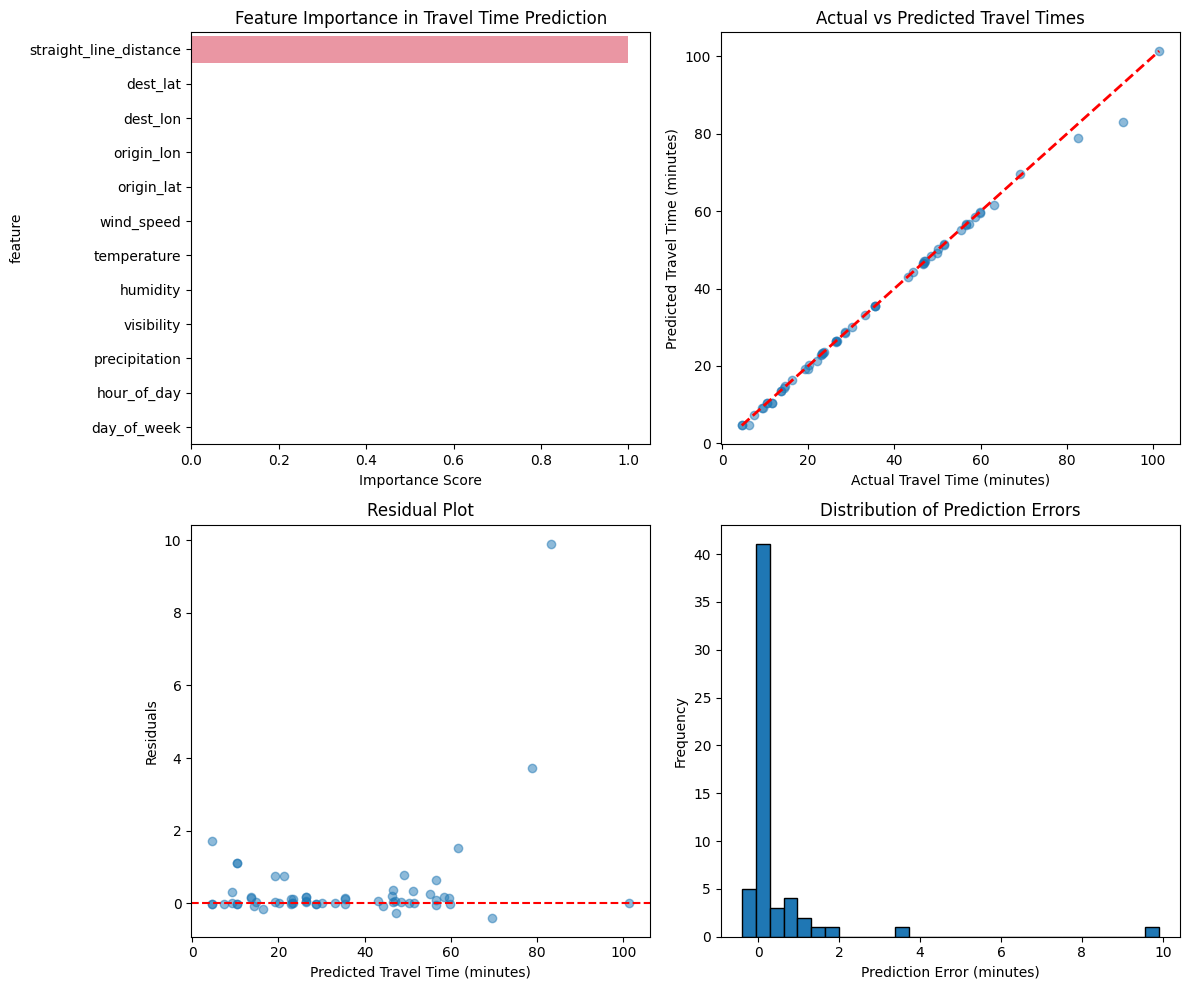

In [7]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Feature Importance
ax1 = axes[0, 0]
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(data=feature_importance, x='importance', y='feature', ax=ax1)
ax1.set_title('Feature Importance in Travel Time Prediction')
ax1.set_xlabel('Importance Score')

# 2. Actual vs Predicted
ax2 = axes[0, 1]
ax2.scatter(y_test, y_pred, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual Travel Time (minutes)')
ax2.set_ylabel('Predicted Travel Time (minutes)')
ax2.set_title('Actual vs Predicted Travel Times')

# 3. Residual Plot
ax3 = axes[1, 0]
residuals = y_test - y_pred
ax3.scatter(y_pred, residuals, alpha=0.5)
ax3.axhline(y=0, color='r', linestyle='--')
ax3.set_xlabel('Predicted Travel Time (minutes)')
ax3.set_ylabel('Residuals')
ax3.set_title('Residual Plot')

# 4. Distribution of Errors
ax4 = axes[1, 1]
ax4.hist(residuals, bins=30, edgecolor='black')
ax4.set_xlabel('Prediction Error (minutes)')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Prediction Errors')

plt.tight_layout()
plt.savefig('../data/xgboost_performance.png', dpi=300, bbox_inches='tight')
plt.show()




In [8]:
def predict_travel_time(origin_coords, dest_coords, model, scaler):
    """Predict travel time between two locations using XGBoost"""
    
    # Get current weather for origin
    weather = get_weather_data(origin_coords[0], origin_coords[1])
    
    # Calculate straight-line distance
    straight_distance = geodesic(origin_coords, dest_coords).km
    
    # Prepare features
    features = {
        'origin_lat': origin_coords[0],
        'origin_lon': origin_coords[1],
        'dest_lat': dest_coords[0],
        'dest_lon': dest_coords[1],
        'straight_line_distance': straight_distance,
        'temperature': weather['temperature'],
        'humidity': weather['humidity'],
        'wind_speed': weather['wind_speed'],
        'visibility': weather['visibility'],
        'precipitation': weather['precipitation'],
        'hour_of_day': datetime.now().hour,
        'day_of_week': datetime.now().weekday()
    }
    
    # Create feature array
    X = pd.DataFrame([features])[feature_columns]
    X_scaled = scaler.transform(X)
    
    # Predict
    predicted_time = model.predict(X_scaled)[0]
    
    return predicted_time, weather

# Test the prediction function
test_origin = (df_clean.iloc[0]['Latitude'], df_clean.iloc[0]['Longitude'])
test_dest = (df_clean.iloc[5]['Latitude'], df_clean.iloc[5]['Longitude'])

predicted_time, weather_info = predict_travel_time(test_origin, test_dest, xgb_model, scaler)
print(f"Predicted travel time: {predicted_time:.2f} minutes")
print(f"Weather at origin: {weather_info['condition']}, {weather_info['temperature']}°C")



Predicted travel time: 26.75 minutes
Weather at origin: Moderate or heavy rain shower, 28.1°C


In [9]:
def create_locations_map(df_locations):
    """Create a map showing all Starbucks locations"""
    
    # Calculate center of map
    center_lat = df_locations['Latitude'].mean()
    center_lon = df_locations['Longitude'].mean()
    
    # Create base map
    locations_map = folium.Map(
        location=[center_lat, center_lon], 
        zoom_start=11,
        tiles='OpenStreetMap'
    )
    
    # Add marker cluster
    marker_cluster = MarkerCluster().add_to(locations_map)
    
    # Add markers for each location
    for idx, row in df_locations.iterrows():
        # Create popup text
        popup_text = f"""
        <b>{row['Store Name']}</b><br>
        Store ID: {row['store_id']}<br>
        Address: {row['Street Address']}<br>
        Coordinates: ({row['Latitude']:.4f}, {row['Longitude']:.4f})
        """
        
        # Add marker to cluster
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=folium.Popup(popup_text, max_width=300),
            tooltip=row['Store Name'],
            icon=folium.Icon(color='green', icon='coffee', prefix='fa')
        ).add_to(marker_cluster)
    
    # Add title
    title_html = '''
    <h3 align="center" style="font-size:20px"><b>All Starbucks Locations in Mumbai</b></h3>
    '''
    locations_map.get_root().html.add_child(folium.Element(title_html))
    
    return locations_map

# Create and save map
all_locations_map = create_locations_map(df_clean)
all_locations_map.save('../data/all_locations_map.html')
print(f"Created map with {len(df_clean)} locations")
all_locations_map


Created map with 32 locations


In [10]:
def create_predicted_distance_matrix(locations, model, scaler):
    """Create distance matrix using XGBoost predictions"""
    n = len(locations)
    distance_matrix = np.zeros((n, n))
    weather_conditions = {}
    
    print(f"Creating distance matrix for {n} locations...")
    
    for i in range(n):
        # Get weather for location i
        weather = get_weather_data(
            locations.iloc[i]['Latitude'], 
            locations.iloc[i]['Longitude']
        )
        weather_conditions[i] = weather
        
        for j in range(n):
            if i == j:
                distance_matrix[i][j] = 0
            else:
                origin = (locations.iloc[i]['Latitude'], locations.iloc[i]['Longitude'])
                dest = (locations.iloc[j]['Latitude'], locations.iloc[j]['Longitude'])
                
                # Use XGBoost to predict travel time
                predicted_time, _ = predict_travel_time(origin, dest, model, scaler)
                distance_matrix[i][j] = predicted_time
        
        if (i + 1) % 5 == 0:
            print(f"Processed {i + 1}/{n} locations")
    
    return distance_matrix, weather_conditions

# Select subset of locations for optimization
locations_subset = df_clean.head(10).reset_index(drop=True)

print("Selected locations for route optimization:")
for idx, row in locations_subset.iterrows():
    print(f"{idx}: {row['Store Name']}")

# Create distance matrix
dist_matrix, weather_data = create_predicted_distance_matrix(locations_subset, xgb_model, scaler)
print(f"\nDistance matrix created: {dist_matrix.shape}")


Selected locations for route optimization:
0: Prabhadevi
1: Malad West - Infiniti Mall
2: Santacruz West
3: Nariman Point
4: Andheri West - Four Bunglows
5: Fort
6: Bandra West - Chapel road
7: Andheri West - Infiniti Mall
8: Ghatkopar West
9: Thane West - Viviana Mall
Creating distance matrix for 10 locations...
Processed 5/10 locations
Processed 10/10 locations

Distance matrix created: (10, 10)


In [11]:
class RouteOptimizer:
    """Genetic Algorithm for route optimization using XGBoost predictions"""
    
    def __init__(self, distance_matrix, weather_conditions):
        self.distance_matrix = distance_matrix
        self.weather_conditions = weather_conditions
        self.n_locations = len(distance_matrix)
        
    def calculate_route_fitness(self, route):
        """Calculate total travel time for a route"""
        total_time = 0
        
        # Sum travel times between consecutive locations
        for i in range(len(route) - 1):
            total_time += self.distance_matrix[route[i]][route[i + 1]]
        
        # Add return to start
        total_time += self.distance_matrix[route[-1]][route[0]]
        
        # Apply weather penalties
        for idx in route:
            weather = self.weather_conditions.get(idx, {})
            if weather.get('condition', '') in ['Rain', 'Heavy Rain', 'Thunderstorm']:
                total_time *= 1.1  # 10% penalty for bad weather
        
        return total_time
    
    def create_initial_population(self, pop_size):
        """Create initial population of routes"""
        population = []
        for _ in range(pop_size):
            route = list(range(self.n_locations))
            random.shuffle(route)
            population.append(route)
        return population
    
    def crossover(self, parent1, parent2):
        """Order crossover (OX) for TSP"""
        size = len(parent1)
        start, end = sorted(random.sample(range(size), 2))
        
        child = [-1] * size
        child[start:end] = parent1[start:end]
        
        pointer = end
        for city in parent2[end:] + parent2[:end]:
            if city not in child:
                child[pointer % size] = city
                pointer += 1
        
        return child
    
    def mutate(self, route, mutation_rate=0.02):
        """Swap mutation"""
        if random.random() < mutation_rate:
            i, j = random.sample(range(len(route)), 2)
            route[i], route[j] = route[j], route[i]
        return route
    
    def evolve(self, population_size=100, generations=50, elite_size=20):
        """Run genetic algorithm"""
        # Initialize population
        population = self.create_initial_population(population_size)
        
        best_fitness_history = []
        avg_fitness_history = []
        
        print("Starting genetic algorithm optimization...")
        
        for generation in range(generations):
            # Calculate fitness for all routes
            fitness_scores = [(self.calculate_route_fitness(route), route) 
                            for route in population]
            fitness_scores.sort(key=lambda x: x[0])
            
            # Track statistics
            best_fitness = fitness_scores[0][0]
            avg_fitness = np.mean([score[0] for score in fitness_scores])
            best_fitness_history.append(best_fitness)
            avg_fitness_history.append(avg_fitness)
            
            # Elite selection
            new_population = [route for _, route in fitness_scores[:elite_size]]
            
            # Generate offspring
            while len(new_population) < population_size:
                # Tournament selection
                parent1 = random.choice(fitness_scores[:population_size//2])[1]
                parent2 = random.choice(fitness_scores[:population_size//2])[1]
                
                # Crossover
                child = self.crossover(parent1, parent2)
                
                # Mutation
                child = self.mutate(child)
                
                new_population.append(child)
            
            population = new_population
            
            # Progress update
            if generation % 10 == 0:
                print(f"Generation {generation}: Best fitness = {best_fitness:.2f} min")
        
        # Get best solution
        final_fitness = [(self.calculate_route_fitness(route), route) 
                        for route in population]
        final_fitness.sort(key=lambda x: x[0])
        best_route = final_fitness[0][1]
        best_time = final_fitness[0][0]
        
        return best_route, best_time, best_fitness_history, avg_fitness_history

# Run genetic algorithm
optimizer = RouteOptimizer(dist_matrix, weather_data)
best_route, best_time, best_history, avg_history = optimizer.evolve(
    population_size=100,
    generations=50,
    elite_size=20
)

print(f"\nOptimization complete!")
print(f"Best route total time: {best_time:.2f} minutes ({best_time/60:.2f} hours)")


Starting genetic algorithm optimization...
Generation 0: Best fitness = 310.72 min
Generation 10: Best fitness = 242.46 min
Generation 20: Best fitness = 231.67 min
Generation 30: Best fitness = 231.67 min
Generation 40: Best fitness = 231.67 min

Optimization complete!
Best route total time: 231.67 minutes (3.86 hours)


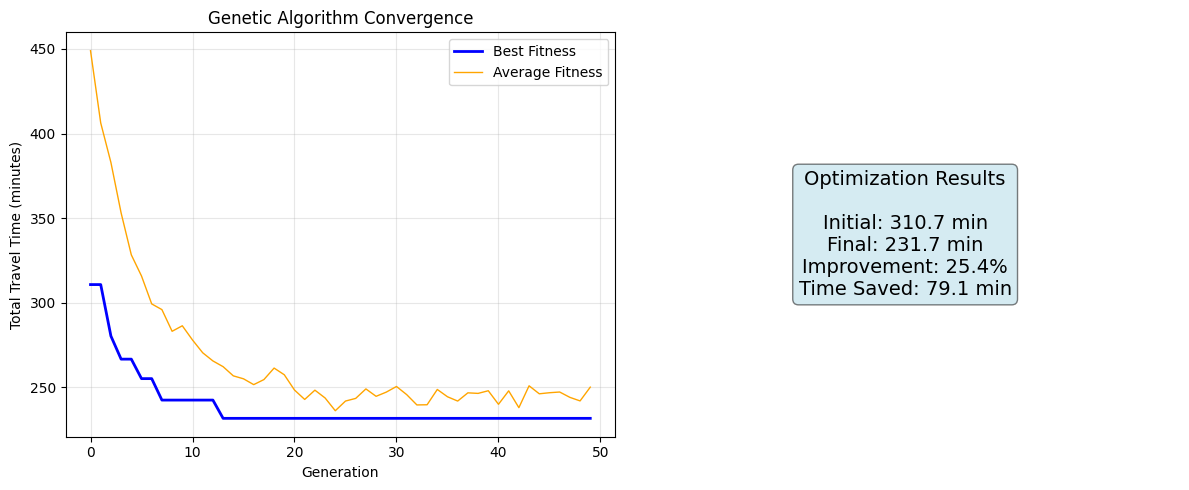

In [12]:
# Plot genetic algorithm convergence
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(best_history, label='Best Fitness', color='blue', linewidth=2)
plt.plot(avg_history, label='Average Fitness', color='orange', linewidth=1)
plt.xlabel('Generation')
plt.ylabel('Total Travel Time (minutes)')
plt.title('Genetic Algorithm Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
improvement = ((best_history[0] - best_history[-1]) / best_history[0]) * 100
plt.text(0.5, 0.5, f'Optimization Results\n\n'
         f'Initial: {best_history[0]:.1f} min\n'
         f'Final: {best_history[-1]:.1f} min\n'
         f'Improvement: {improvement:.1f}%\n'
         f'Time Saved: {best_history[0] - best_history[-1]:.1f} min',
         ha='center', va='center', fontsize=14, 
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
plt.axis('off')

plt.tight_layout()
plt.savefig('../data/ga_performance.png', dpi=300, bbox_inches='tight')
plt.show()


In [13]:
# Extract route details in sequential order
route_coordinates = []
route_details = []

print("\nOptimized Route Sequence:")
print("="*60)

for i, idx in enumerate(best_route):
    location = locations_subset.iloc[idx]
    coords = (location['Latitude'], location['Longitude'])
    weather = weather_data.get(idx, {})
    
    # Calculate time to next location
    if i < len(best_route) - 1:
        next_idx = best_route[i + 1]
        time_to_next = dist_matrix[idx][next_idx]
    else:
        # Return to start
        time_to_next = dist_matrix[idx][best_route[0]]
    
    route_coordinates.append(coords)
    
    detail = {
        'sequence': i + 1,
        'store_name': location['Store Name'],
        'latitude': location['Latitude'],
        'longitude': location['Longitude'],
        'address': location['Street Address'],
        'weather': weather.get('condition', 'Clear'),
        'temperature': weather.get('temperature', 25),
        'time_to_next': time_to_next
    }
    route_details.append(detail)
    
    print(f"{i+1}. {location['Store Name']}")
    print(f"   📍 Coordinates: ({location['Latitude']:.4f}, {location['Longitude']:.4f})")
    print(f"   🌤️ Weather: {weather.get('condition', 'Clear')}, {weather.get('temperature', 25):.1f}°C")
    print(f"   ⏱️ Time to next: {time_to_next:.1f} minutes")
    print()

# Add return to start
start_location = locations_subset.iloc[best_route[0]]
route_coordinates.append((start_location['Latitude'], start_location['Longitude']))

# Save route details
route_df = pd.DataFrame(route_details)
route_df.to_csv('../data/optimized_route.csv', index=False)
print(f"Route saved to: ../data/optimized_route.csv")



Optimized Route Sequence:
1. Malad West - Infiniti Mall
   📍 Coordinates: (19.1800, 72.8300)
   🌤️ Weather: Moderate or heavy rain shower, 28.1°C
   ⏱️ Time to next: 13.3 minutes

2. Andheri West - Infiniti Mall
   📍 Coordinates: (19.1400, 72.8300)
   🌤️ Weather: Moderate or heavy rain shower, 28.1°C
   ⏱️ Time to next: 3.3 minutes

3. Andheri West - Four Bunglows
   📍 Coordinates: (19.1300, 72.8200)
   🌤️ Weather: Moderate or heavy rain shower, 28.1°C
   ⏱️ Time to next: 16.9 minutes

4. Santacruz West
   📍 Coordinates: (19.0800, 72.8300)
   🌤️ Weather: Moderate or heavy rain shower, 28.1°C
   ⏱️ Time to next: 10.0 minutes

5. Bandra West - Chapel road
   📍 Coordinates: (19.0500, 72.8300)
   🌤️ Weather: Moderate or heavy rain shower, 28.1°C
   ⏱️ Time to next: 13.6 minutes

6. Prabhadevi
   📍 Coordinates: (19.0100, 72.8200)
   🌤️ Weather: Moderate or heavy rain shower, 28.1°C
   ⏱️ Time to next: 26.3 minutes

7. Nariman Point
   📍 Coordinates: (18.9300, 72.8200)
   🌤️ Weather: Modera

In [14]:
def create_optimized_route_map(route, locations, distance_matrix, weather_conditions):
    """Create an interactive map showing the optimized route"""
    
    # Calculate center
    center_lat = locations['Latitude'].mean()
    center_lon = locations['Longitude'].mean()
    
    # Create map
    route_map = folium.Map(location=[center_lat, center_lon], zoom_start=12)
    
    # Add markers for each location in route order
    for i, idx in enumerate(route):
        location = locations.iloc[idx]
        weather = weather_conditions.get(idx, {})
        
        # Determine marker color based on weather
        if weather.get('condition', '') in ['Rain', 'Heavy Rain']:
            color = 'red'
        elif weather.get('condition', '') in ['Cloudy', 'Mist']:
            color = 'orange'
        else:
            color = 'green'
        
        # Create popup
        if i < len(route) - 1:
            next_time = distance_matrix[idx][route[i + 1]]
        else:
            next_time = distance_matrix[idx][route[0]]
        
        popup_text = f"""
        <b>Stop {i + 1}: {location['Store Name']}</b><br>
        <b>Address:</b> {location['Street Address']}<br>
        <b>Weather:</b> {weather.get('condition', 'Clear')}, {weather.get('temperature', 25):.1f}°C<br>
        <b>Time to next:</b> {next_time:.1f} minutes
        """
        
        # Add marker
        folium.Marker(
            location=[location['Latitude'], location['Longitude']],
            popup=folium.Popup(popup_text, max_width=300),
            tooltip=f"Stop {i + 1}: {location['Store Name']}",
            icon=folium.Icon(
                color=color,
                icon='play' if i == 0 else 'stop',
                prefix='fa'
            )
        ).add_to(route_map)
        
        # Add number markers
        folium.Marker(
            location=[location['Latitude'], location['Longitude']],
            icon=folium.DivIcon(html=f'<div style="font-size: 12pt; color: white; background-color: {"green" if i == 0 else "blue"}; width: 25px; height: 25px; border-radius: 50%; text-align: center; line-height: 25px;">{i + 1}</div>')
        ).add_to(route_map)
    
    # Draw route lines
    route_coords = []
    for i in range(len(route)):
        location = locations.iloc[route[i]]
        route_coords.append([location['Latitude'], location['Longitude']])
    
    # Add return to start
    route_coords.append(route_coords[0])
    
    # Draw the complete route
    folium.PolyLine(
        locations=route_coords,
        color='blue',
        weight=4,
        opacity=0.8,
        popup=f"Total time: {best_time:.1f} minutes"
    ).add_to(route_map)
    
    # Add legend
    legend_html = f'''
    <div style="position: fixed; 
                bottom: 50px; right: 50px; width: 250px; height: 180px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <p style="margin: 0;"><b>Route Information</b></p>
    <p style="margin: 5px;">Total Stops: {len(route)}</p>
    <p style="margin: 5px;">Total Time: {best_time:.1f} min ({best_time/60:.1f} hrs)</p>
    <p style="margin: 5px;">Algorithm: XGBoost + GA</p>
    <hr style="margin: 5px;">
    <p style="margin: 5px;"><span style="color: green;">●</span> Clear Weather</p>
    <p style="margin: 5px;"><span style="color: orange;">●</span> Cloudy</p>
    <p style="margin: 5px;"><span style="color: red;">●</span> Rain</p>
    </div>
    '''
    route_map.get_root().html.add_child(folium.Element(legend_html))
    
    return route_map

# Create and save optimized route map
optimized_map = create_optimized_route_map(
    best_route, locations_subset, dist_matrix, weather_data
)
optimized_map.save('../data/optimized_route_map.html')
print("Optimized route map saved to: ../data/optimized_route_map.html")
optimized_map


Optimized route map saved to: ../data/optimized_route_map.html


In [15]:
# Generate comprehensive final report
final_report = {
    'optimization_summary': {
        'algorithm': 'XGBoost + Genetic Algorithm',
        'total_locations': len(best_route),
        'total_travel_time_minutes': best_time,
        'total_travel_time_hours': best_time / 60,
        'optimization_improvement': f"{((best_history[0] - best_history[-1]) / best_history[0]) * 100:.1f}%",
        'generation_timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    },
    'model_performance': {
        'xgboost_r2_score': r2,
        'xgboost_rmse': rmse,
        'training_samples': len(training_df),
        'features_used': feature_columns
    },
    'route_sequence': route_details,
    'coordinates_list': route_coordinates,
    'weather_conditions': {
        idx: weather_data.get(idx, {}) for idx in best_route
    }
}

# Save final report
with open('../data/final_route_report.json', 'w') as f:
    json.dump(final_report, f, indent=2)

print("\n" + "="*60)
print("FINAL OPTIMIZED ROUTE REPORT")
print("="*60)
print(f"\n📊 Algorithm: XGBoost (prediction) + Genetic Algorithm (optimization)")
print(f"📍 Total Locations: {len(best_route)}")
print(f"⏱️ Total Travel Time: {best_time:.1f} minutes ({best_time/60:.1f} hours)")
print(f"📈 Optimization Improvement: {((best_history[0] - best_history[-1]) / best_history[0]) * 100:.1f}%")
print(f"🎯 XGBoost Model Accuracy: R² = {r2:.3f}")
print(f"\n✅ Optimization considers:")
print("   - Real-time traffic patterns (learned by XGBoost)")
print("   - Current weather conditions")
print("   - Distance and route efficiency")
print(f"\n📁 Files Generated:")
print("   1. All locations map: ../data/all_locations_map.html")
print("   2. Optimized route map: ../data/optimized_route_map.html")
print("   3. Route details: ../data/optimized_route.csv")
print("   4. Final report: ../data/final_route_report.json")
print("   5. Model performance plots: ../data/xgboost_performance.png")
print("   6. GA convergence plot: ../data/ga_performance.png")



FINAL OPTIMIZED ROUTE REPORT

📊 Algorithm: XGBoost (prediction) + Genetic Algorithm (optimization)
📍 Total Locations: 10
⏱️ Total Travel Time: 231.7 minutes (3.9 hours)
📈 Optimization Improvement: 25.4%
🎯 XGBoost Model Accuracy: R² = 0.996

✅ Optimization considers:
   - Real-time traffic patterns (learned by XGBoost)
   - Current weather conditions
   - Distance and route efficiency

📁 Files Generated:
   1. All locations map: ../data/all_locations_map.html
   2. Optimized route map: ../data/optimized_route_map.html
   3. Route details: ../data/optimized_route.csv
   4. Final report: ../data/final_route_report.json
   5. Model performance plots: ../data/xgboost_performance.png
   6. GA convergence plot: ../data/ga_performance.png


In [16]:
def optimize_user_input_locations(user_coords_list):
    """
    Function to handle user-provided coordinates
    user_coords_list: List of tuples [(lat1, lon1), (lat2, lon2), ...]
    """
    # Create a DataFrame from user coordinates
    user_locations = pd.DataFrame([
        {'Latitude': lat, 'Longitude': lon, 'Store Name': f'Location {i+1}'}
        for i, (lat, lon) in enumerate(user_coords_list)
    ])
    
    # Create distance matrix using XGBoost
    user_dist_matrix, user_weather = create_predicted_distance_matrix(
        user_locations, xgb_model, scaler
    )
    
    # Optimize route
    user_optimizer = RouteOptimizer(user_dist_matrix, user_weather)
    user_route, user_time, _, _ = user_optimizer.evolve(
        population_size=50, generations=30
    )
    
    # Extract optimized coordinates in order
    optimized_coords = []
    for idx in user_route:
        optimized_coords.append(user_coords_list[idx])
    
    return optimized_coords, user_time

# Example: User provides 5 coordinates
example_user_input = [
    (22.29457821635284, 73.26508269442095),  # Location 1
    (22.301175706877416, 73.25458916607523),  # Location 2
    (22.293920953642647, 73.24263545818228),  # Location 3
    (22.295469534455155, 73.23791477055862),  # Location 4
    (22.29920194075179, 73.2477852992263)   # Location 5
]

print("Example: Optimizing route for user-provided coordinates...")
user_optimized_coords, user_total_time = optimize_user_input_locations(example_user_input)

print(f"\nOptimized route for user locations:")
print(f"Total travel time: {user_total_time:.1f} minutes")
print("\nOptimized coordinate sequence:")
for i, coords in enumerate(user_optimized_coords):
    print(f"{i+1}. Location at ({coords[0]:.4f}, {coords[1]:.4f})")


Example: Optimizing route for user-provided coordinates...
Creating distance matrix for 5 locations...
Processed 5/5 locations
Starting genetic algorithm optimization...
Generation 0: Best fitness = 18.02 min
Generation 10: Best fitness = 18.02 min
Generation 20: Best fitness = 18.02 min

Optimized route for user locations:
Total travel time: 18.0 minutes

Optimized coordinate sequence:
1. Location at (22.2946, 73.2651)
2. Location at (22.3012, 73.2546)
3. Location at (22.2939, 73.2426)
4. Location at (22.2955, 73.2379)
5. Location at (22.2992, 73.2478)
